In [2]:
# Importing basic libraries for the project

import os
import zipfile
import shutil
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision

import torch.nn as nn

import torch.optim as optim

from tqdm import tqdm  # for progress bars

import torch.nn.functional as F  # Import F for functional operations





Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.9764706].


Device in use: cuda


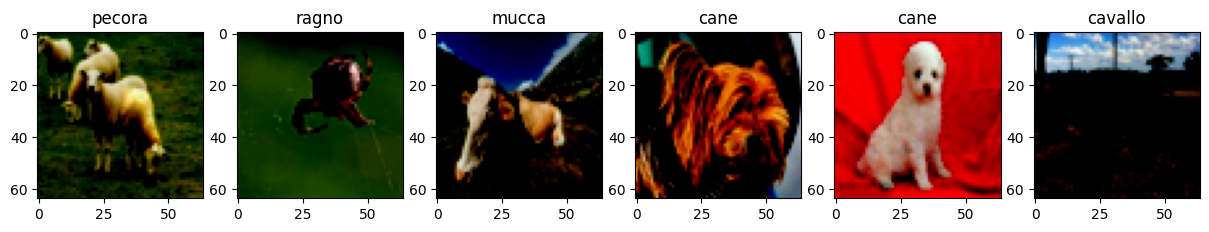

In [3]:
# ./data/animals10"
from torchvision import transforms
from torchvision import datasets


# Use same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)

#define where the raw data / dataset is located
data_dir = "../data/animals10"

#transformation --resize images, convert to tensors, normalize
transform = transforms.Compose([
    transforms.Resize((64, 64)),        # Resize images to 32 (it was 64 before and it was too big/slow) --22 sec per epoch
    transforms.ToTensor(),              # Convert images to PyTorch tensors
    transforms.Normalize((0.5,),(0.5))  # Normalize pixel values to [-1, 1] 
])

# Load images from the folder
train_data = datasets.ImageFolder(root=data_dir, transform=transform)

# split between training and validation data
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])

# data loader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True) # change batch size to 16, it was too slow -- 22 sec per epoch
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# present few images
def show_images(dataset, num=6):
    fig, axes = plt.subplots(1, num, figsize=(15, 4))
    for i in range(num):
        img, label = dataset[i]
        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].set_title(train_data.dataset.classes[label])
    plt.show()
show_images(train_data)


In [4]:
import torch
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.device_count())
#print(torch.cuda.get_device_name(0))


True
1


In [5]:

class AnimalCNN(nn.Module):
    def __init__(self):
        super(AnimalCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1) # input channel 3 (RGB), output 16
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # downsample by 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)  
        self.fc2 = nn.Linear(128, 10) # 10 output classees
        #self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # Conv1 + ReLU + Pool
        x = self.pool(F.relu(self.conv2(x)))    # Conv2 + ReLU + Pool 
        x = x.view(-1, 32 * 16 * 16)            # flatten
        x = F.relu(self.fc1(x))                 # fully connected layer
        x = self.fc2(x)                     # output layer  
        return x
    
# Instantiate the model
model = AnimalCNN().to(device)
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer




AnimalCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [6]:
print("Using GPU?", torch.cuda.is_available())
print(device)
print(next(model.parameters()).device)



Using GPU? True
cuda
cuda:0


In [ ]:
# Obs: 22 seconds to run 1 epoch on a GPU it was too slow, I will reduce image size from 64 to 32

import copy

# Early stopping 
best_val_loss = float('inf')    # Best validation loss seen so far
patience = 2                   # number of epochs to wait for improvement
patience_counter = 0           # Counter for patience
best_model_wts = copy.deepcopy(model.state_dict()) # Save the best model weights



# Training
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for images, labels in progress_bar:

        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #backward pass and optimize
        loss.backward()
        optimizer.step()

        #track loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # this is to follow while training because the process is very slow
        progress_bar.set_postfix({
            "Loss": f"{running_loss / (total / images.size(0)):.4f}",
            "Acc": f"{100 * correct / total:.2f}%"
        })

    # Calculate validation    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    train_acc = 100 * correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss) 

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {train_acc:.2f}%")

    # Early Stopping Logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = copy.deepcopy(model.state_dict())  # Save weights
        # Save best model weights to disk
        torch.save(model.state_dict(), 'models/best_model.pth')
        print("🔍 Validation loss improved — saving best model.")
    else:
        patience_counter += 1
        print(f"⏳ No improvement in val loss. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("🛑 Early stopping triggered!")
            break


print("✅ Training completed!")


'''

Q&A

How do I know if my model is overfitting?

Val Loss = 1.18: What does it mean?
Val Loss = 1.18 means the model is making some mistakes on the validation set, but it's not catastrophic. A lower val loss indicates better performance.


🧠 Overfitting = High training performance, poor generalization
🚩 Warning signs of overfitting:

Training accuracy keeps going up, but validation accuracy stays flat or goes down

Training loss keeps going down, but validation loss goes up

Your model performs well on training data, but poorly on new, unseen data



-------------------------------


What is regularization (e.g., weight decay)?

What is data augmentation?




🔧 What to do if overfitting happens?
Reduce model complexity (fewer layers or neurons)

Add more Dropout

Use data augmentation (more diverse training data)

Try regularization (e.g., weight decay)

Use early stopping — which you already did! ✅

-------------------------------

Where are the layers and the neurons?
The layers and neurons are defined in the AnimalCNN class.
The model has 2 convolutional layers (conv1 and conv2) and 2 fully connected layers (fc1 and fc2). The number of neurons in each layer is defined by the number of output channels in the convolutional layers and the number of units in the fully connected layers.

How to make decisions about dropout?
The decision to add dropout depends on the model's performance. If you observe signs of overfitting (e.g., high training accuracy but low validation accuracy), you can consider adding dropout layers to reduce overfitting.
You can start with a dropout rate of 0.5 and adjust it based on the model's performance. If the model is still overfitting, you can increase the dropout rate.

What the dropout means?
Dropout is a regularization technique used to prevent overfitting in neural networks. It randomly sets a fraction of the input units to zero during training, which helps the model generalize better by reducing its reliance on specific neurons.
It works by randomly dropping out (setting to zero) a certain percentage of neurons during training, which forces the network to learn more robust features that are not reliant on any specific neuron.
It helps to prevent overfitting by making the model less sensitive to the specific weights of individual neurons.
It is a technique used to prevent overfitting in neural networks. During training, dropout randomly sets a fraction of the input units to zero, which helps the model generalize better by reducing its reliance on specific neurons



Where can I add more Dropout?
You can add more Dropout layers after the fully connected layers (fc1 and fc2) in the AnimalCNN class. For example, you can add a dropout layer with a dropout rate of 0.5 after fc1 like this:
self.dropout = nn.Dropout(0.5)



'''

Epoch 1/10: 100%|██████████| 655/655 [00:27<00:00, 23.59batch/s, Loss=0.7750, Acc=42.36%]


Epoch [1/10], Train Loss: 1.6519, Val Loss: 1.3630, Accuracy: 42.36%
🔍 Validation loss improved — saving best model.


Epoch 2/10: 100%|██████████| 655/655 [00:24<00:00, 26.56batch/s, Loss=0.5844, Acc=57.75%]


Epoch [2/10], Train Loss: 1.2457, Val Loss: 1.1871, Accuracy: 57.75%
🔍 Validation loss improved — saving best model.


Epoch 3/10: 100%|██████████| 655/655 [00:24<00:00, 26.57batch/s, Loss=0.4864, Acc=64.52%]


Epoch [3/10], Train Loss: 1.0368, Val Loss: 1.1756, Accuracy: 64.52%
🔍 Validation loss improved — saving best model.


Epoch 4/10: 100%|██████████| 655/655 [00:24<00:00, 26.72batch/s, Loss=0.3947, Acc=71.84%]


Epoch [4/10], Train Loss: 0.8413, Val Loss: 1.1748, Accuracy: 71.84%
🔍 Validation loss improved — saving best model.


Epoch 5/10: 100%|██████████| 655/655 [00:24<00:00, 26.73batch/s, Loss=0.3056, Acc=78.21%]


Epoch [5/10], Train Loss: 0.6515, Val Loss: 1.1629, Accuracy: 78.21%
🔍 Validation loss improved — saving best model.


Epoch 6/10: 100%|██████████| 655/655 [00:24<00:00, 26.53batch/s, Loss=0.2177, Acc=84.68%]


Epoch [6/10], Train Loss: 0.4640, Val Loss: 1.3334, Accuracy: 84.68%
⏳ No improvement in val loss. Patience: 1/2


Epoch 7/10: 100%|██████████| 655/655 [00:24<00:00, 26.47batch/s, Loss=0.1478, Acc=89.66%]


Epoch [7/10], Train Loss: 0.3150, Val Loss: 1.4714, Accuracy: 89.66%
⏳ No improvement in val loss. Patience: 2/2
🛑 Early stopping triggered!
✅ Training completed!
